<a href="https://colab.research.google.com/github/shantanu1singh/ml-practice/blob/master/collab/Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


## Feature scaling/normalization

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Build model

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()                                  
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    # The network ends with a single unit and no activation (it will be a linear layer). 
    # This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). 
    # Applying an activation function would constrain the range the output can take
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold cross validation (since input data size is small)

In [5]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    model.fit(partial_train_data, partial_train_targets,                     
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)      
    all_scores.append(val_mae)

all_scores
np.mean(all_scores) # Eg. A result of 3 indicates that the mean prediction is off by 3k dollars. This is significant considering housing prices in dataset are between 10k and 30k

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


2.483935296535492

## Save validation log after each epoch (Using 500 epochs to see if we can do better)

In [8]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    history = model.fit(partial_train_data, partial_train_targets,           
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Get average MAE (Mean absolute error) history

In [9]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## Plotting MAE by epoch

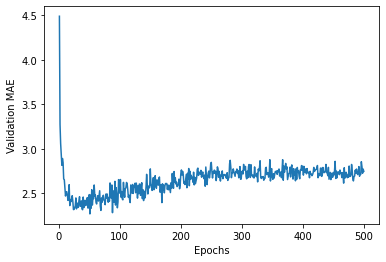

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:

# Omit the first 10 data points, which are on a different scale than the rest of the curve.
# Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

## Better curve

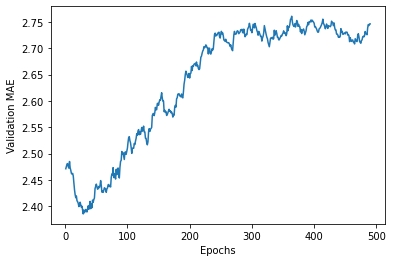

In [11]:
# It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:

# Omit the first 10 data points, which are on a different scale than the rest of the curve.
# Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Train final model

In [12]:
# From above, we see that model performance deteriorates after 80 epochs
model = build_model()                                                     
model.fit(train_data, train_targets,                                      
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mse_score
test_mae_score

4/4 [==============================] - 0s 2ms/step - loss: 18.6456 - mae: 2.8183


2.818284511566162